# ¿Cuál es la mejor tarifa?

La empresa Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [56]:
# Cargar todas las librerías
from scipy import stats as st
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as mt


## Cargar datos

In [57]:
# Carga los archivos de datos en diferentes DataFrames
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')

## Preparar los datos

## Tarifas

In [58]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [59]:
# Imprime una muestra de los datos para las tarifas
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


De lo que se puede apreciar, esta tabla no cuenta con valores nulos ni repetidos (solo cuenta con dos valores). Adicionalmente, todas las columnas poseen los tipos de dato correctos.
No se realizan modificaciones.

## Usuarios/as

In [62]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [63]:
# Imprime una muestra de datos para usuarios
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Se observa que solo la columna churn_date posee valores nulos. Esto es debido al comportamiento propio de la variable, un valor nulo indica que la persona usaba el plan en ese momento.
Los tipos de datos de las columnas son adecuados. El tipo de dato de la columna user_id es un numero, podria ser convertido a string dado que no guarda informacion numerica. Somos conscientes de la inforacion que contiene y guardarla como int ocupa menos espacio. Se decide por dejarla como int.

### Corregir los datos

In [64]:
# Esta tabla se encuentra en orden, nada por corregir
sum(users.duplicated())

0

## Llamadas

In [66]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [67]:
# Imprime una muestra de datos para las llamadas
calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Esta tabla no presenta datos nulos. Las columnas poseen el tipo de dato correcto (el caso de user_id fue explicado anteriormente), salvo por la columna call_date
Para el analisis, el tipo de dato de la columna call_date sera convertido a tipo datetime para poder agrupar la informacion por periodos mensuales.

### Corregir los datos

In [68]:
# Esta tabla no presenta duplicados explicitos
sum(calls.duplicated())

0

In [69]:
# Se convierte el tipo de dato de la columna a datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

In [70]:
# Dado que la empresa cobra las llamadas en minutos y redondeando hacia arriba
# Seria conveniente tener una columna con dicha informacion
calls['charged_duration'] = np.ceil(calls['duration']).astype('int')
calls

,id,user_id,call_date,duration,charged_duration
0,1000_93,1000,2018-12-27,8.52,9
1,1000_145,1000,2018-12-27,13.66,14
2,1000_247,1000,2018-12-27,14.48,15
3,1000_309,1000,2018-12-28,5.76,6
4,1000_380,1000,2018-12-30,4.22,5
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,9
137731,1499_200,1499,2018-10-20,10.89,11
137732,1499_201,1499,2018-09-21,8.12,9
137733,1499_202,1499,2018-10-10,0.37,1


## Mensajes

In [71]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [72]:
# Imprime una muestra de datos para los mensajes
messages.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Esta tabla no presenta datos nulos. Los tipos de dato son los adecuados (user_id ya fue explicado), salvo message_date que debe convertirse a tipo datetime para hacer analisis con las fechas.

### Corregir los datos

In [73]:
# Esta tabla no cuenta con duplicados explicitos
sum(messages.duplicated())

0

In [74]:
# Se convierte el tipo de dato de la columna a datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

In [76]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [77]:
# Imprime una muestra de datos para el tráfico de internet
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Esta tabla no presenta datos nulos. Los tipos de dato son los correctos (user_id ya explicado), savlo session_date que debe ser convertido a datetime para procesar la informacion en la columna.

### Corregir los datos

In [78]:
# Esta tabla no cuenta con duplicados explicitos
sum(internet.duplicated())

0

In [79]:
# Se convierte el tipo de dato de la columna a datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Estudiar las condiciones de las tarifas

In [81]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

In [82]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
# Se agrupan los datos por usuario y por mes y se cuenta la cantidad de isntancias
calls_user_month = calls.groupby(by=['user_id', calls['call_date'].dt.month])['id'].count()
# Se convierte a un df para mejor manejo posterior
calls_user_month = calls_user_month.rename('calls').to_frame()
# Se renombra el indice a month para ser mas descriptivo
calls_user_month.index.rename('month', level=1, inplace=True)
calls_user_month

calls
user_id month       
1000    12        16
1001    8         27
        9         49
        10        65
        11        64
...              ...
1498    12        39
1499    9         41
        10        53
        11        45
        12        65

[2258 rows x 1 columns]

In [83]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
# Se agrupan los datos por usuario y por mes y se suman los minutos
calls_minutes_user_month = calls.groupby(by=['user_id', calls['call_date'].dt.month])['charged_duration'].sum()
# Se convierte a df para mejor manejo posterior
calls_minutes_user_month = calls_minutes_user_month.to_frame()
# Se renombra el indice a month para ser mas descriptivo
calls_minutes_user_month.index.rename('month', level=1, inplace=True)
calls_minutes_user_month

charged_duration
user_id month                  
1000    12                  124
1001    8                   182
        9                   315
        10                  393
        11                  426
...                         ...
1498    12                  339
1499    9                   346
        10                  385
        11                  308
        12                  496

[2258 rows x 1 columns]

In [84]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
# Se agrupa por usuario y por mes y se cuentan las instancias
messages_user_month = messages.groupby(by=['user_id', calls['call_date'].dt.month])['id'].count()
# Se tranforma a df para mejor manejo posterior
messages_user_month = messages_user_month.rename('messages').to_frame()
# Se renombra el indice a month para ser mas descriptivo
messages_user_month.index.rename('month', level=1, inplace=True)
messages_user_month

messages
user_id month          
1000    12           11
1001    8            21
        9            39
        10           52
        11           48
...                 ...
1497    8             4
        9             4
        10            4
        11           10
        12            5

[2950 rows x 1 columns]

In [85]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
# Se agrupa por usuario y por mes y se suman los mbs
internet_MB_user_month = internet.groupby(by=['user_id', calls['call_date'].dt.month])['mb_used'].sum()
# Se convierte a df para mejor manejo posterior
internet_MB_user_month = internet_MB_user_month.to_frame()
# Se renombra el indice a month para ser mas descriptivo
internet_MB_user_month.index.rename('month', level=1, inplace=True)
internet_MB_user_month

mb_used
user_id month          
1000    12      1901.47
1001    8       7131.50
        9      13311.04
        10     20406.45
        11     20873.07
...                 ...
1499    8       9488.37
        9       9542.05
        10      5879.22
        11     10283.54
        12     14310.33

[3611 rows x 1 columns]

In [86]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
# Se usa el metodo merge() para la fusion en user_id y month. Concat no hubiera funcionado ya que los indices de las tablas no son los mismmos
calls_duration_messages_mb_users_month = calls_user_month.merge(calls_minutes_user_month, on=['user_id', 'month']).merge(
messages_user_month, on=['user_id', 'month'], how='outer').merge(
    internet_MB_user_month, on=['user_id', 'month'], how='outer').sort_index()
calls_duration_messages_mb_users_month

calls  charged_duration  messages   mb_used
user_id month                                             
1000    12      16.0             124.0      11.0   1901.47
1001    8       27.0             182.0      21.0   7131.50
        9       49.0             315.0      39.0  13311.04
        10      65.0             393.0      52.0  20406.45
        11      64.0             426.0      48.0  20873.07
...              ...               ...       ...       ...
1499    8        NaN               NaN       NaN   9488.37
        9       41.0             346.0       NaN   9542.05
        10      53.0             385.0       NaN   5879.22
        11      45.0             308.0       NaN  10283.54
        12      65.0             496.0       NaN  14310.33

[4310 rows x 4 columns]

In [87]:
# Añade la información de la tarifa
# Se une la informacion de usuarios y de los planes en una sola tabla con el metodo merge() en la columna plan
#users_plans = users[['user_id', 'plan']].merge(plans, left_on='plan', right_on='plan_name').sort_values('user_id').set_index('user_id')
users_plans = users.merge(plans, left_on='plan', right_on='plan_name').sort_values('user_id').set_index('user_id')
users_plans


,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
user_id,,,,,,,,,,,,,,,
1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate
1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate


In [88]:
# Se fusiona la informacion anterior con la de los consumos usando el metodo join(), ya que se comparte el indice user_id
all_users_month_plans = calls_duration_messages_mb_users_month.join(users_plans, how='inner').fillna(0)
all_users_month_plans

calls  charged_duration  messages   mb_used first_name  \
user_id month                                                           
1000    12      16.0             124.0      11.0   1901.47   Anamaria   
1001    8       27.0             182.0      21.0   7131.50     Mickey   
        9       49.0             315.0      39.0  13311.04     Mickey   
        10      65.0             393.0      52.0  20406.45     Mickey   
        11      64.0             426.0      48.0  20873.07     Mickey   
...              ...               ...       ...       ...        ...   
1499    8        0.0               0.0       0.0   9488.37      Shena   
        9       41.0             346.0       0.0   9542.05      Shena   
        10      53.0             385.0       0.0   5879.22      Shena   
        11      45.0             308.0       0.0  10283.54      Shena   
        12      65.0             496.0       0.0  14310.33      Shena   

               last_name  age                                   city  \
user_id month                                                          
1000    12         Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1001    8      Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
        9      Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
        10     Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
        11     Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
...                  ...  ...                                    ...   
1499    8        Dickson   37      Orlando-Kissimmee-Sanford, FL MSA   
        9        Dickson   37      Orlando-Kissimmee-Sanford, FL MSA   
        10       Dickson   37      Orlando-Kissimmee-Sanford, FL MSA   
        11       Dickson   37      Orlando-Kissimmee-Sanford, FL MSA   
        12       Dickson   37      Orlando-Kissimmee-Sanford, FL MSA   

                 reg_date      plan churn_date  messages_included  \
user_id month                                                       
1000    12     2018-12-24  ultimate          0               1000   
1001    8      2018-08-13      surf          0                 50   
        9      2018-08-13      surf          0                 50   
        10     2018-08-13      surf          0                 50   
        11     2018-08-13      surf          0                 50   
...                   ...       ...        ...                ...   
1499    8      2018-05-06      surf          0                 50   
        9      2018-05-06      surf          0                 50   
        10     2018-05-06      surf          0                 50   
        11     2018-05-06      surf          0                 50   
        12     2018-05-06      surf          0                 50   

               mb_per_month_included  minutes_included  usd_monthly_pay  \
user_id month                                                             
1000    12                     30720              3000               70   
1001    8                      15360               500               20   
        9                      15360               500               20   
        10                     15360               500               20   
        11                     15360               500               20   
...                              ...               ...              ...   
1499    8                      15360               500               20   
        9                      15360               500               20   
        10                     15360               500               20   
        11                     15360               500               20   
        12                     15360               500               20   

               usd_per_gb  usd_per_message  usd_per_minute plan_name  
user_id month                                                         
1000    12              7             0.01            0.01  ultimate  
1001    8              10             0.0

In [89]:
# Calcula el ingreso mensual para cada usuario
# Ingreso por llamadas
income_calls_user_month = ((all_users_month_plans['charged_duration'] - all_users_month_plans['minutes_included']).clip(0, None))*all_users_month_plans['usd_per_minute']
# Ingreso por mensajes
income_messages_user_month = ((all_users_month_plans['messages'] - all_users_month_plans['messages_included']).clip(0, None))*all_users_month_plans['usd_per_message']
# Ingreso por mbs
income_mb_user_month = (np.ceil(all_users_month_plans['mb_used'] / 1024) - np.ceil(all_users_month_plans['mb_per_month_included'] / 1024)).clip(0, None)*all_users_month_plans['usd_per_gb']
# Ingreso total
income_total_users_month = income_calls_user_month + income_messages_user_month + income_mb_user_month + all_users_month_plans['usd_monthly_pay']
income_total_users_month

user_id  month
1000     12       70.00
1001     8        20.00
         9        20.00
         10       70.06
         11       80.00
                  ...  
1499     8        20.00
         9        20.00
         10       20.00
         11       20.00
         12       20.00
Length: 4310, dtype: float64

## Estudia el comportamiento de usuario

### Llamadas

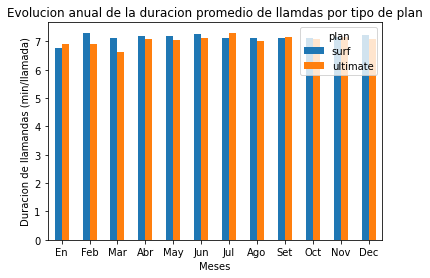

In [90]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
total_calls_duration_month = all_users_month_plans[['charged_duration', 'plan', 'calls']].groupby(by=['month', 'plan'])[['charged_duration', 'calls']].sum()['charged_duration']
total_calls_number_month = all_users_month_plans[['charged_duration', 'plan', 'calls']].groupby(by=['month', 'plan'])[['charged_duration', 'calls']].sum()['calls']
avg_call_duration_month = total_calls_duration_month / total_calls_number_month
avg_call_duration_month.unstack().plot(kind='bar',
                                      rot=0,
                                      xlabel='Meses', 
                                    ylabel='Duracion de llamandas (min/llamada)',
                                    title='Evolucion anual de la duracion promedio de llamdas por tipo de plan')
plt.xticks(range(12), ['En', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dec'])
plt.show()

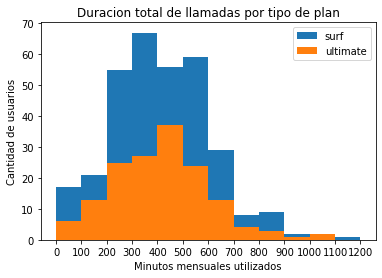

In [91]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# pd.pivot_table(all_users_month_plans[['charged_duration', 'plan']].replace(0, np.nan), values='charged_duration', index='user_id', columns=['plan'], aggfunc='mean')
# Se filtra los usuarios del plan surf. La columna de duracion se agrupa por usuario y se saca el promedio sobre los meses
all_users_month_plans[all_users_month_plans['plan'] == 'surf']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().plot(kind='hist',
                                                                                                                                        bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],
                                                                                                                                        alpha=1)
# Se filtra los usuarios del plan ultimate. La columna de duracion se agrupa por usuario y se saca el promedio sobre los meses
all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().plot(kind='hist',
                                                                                                                                    bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],
                                                                                                                                    alpha=1)

plt.xlabel('Minutos mensuales utilizados')
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
plt.ylabel('Cantidad de usuarios')
plt.legend(['surf', 'ultimate'])
plt.title('Duracion total de llamadas por tipo de plan')
plt.show()



In [92]:
# Calcula la media y la varianza de la duración mensual de llamadas.
# Para el plan surf
# Se calcula la media
avg_month_duration_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().mean()
# Se calcula la varianza
var_month_duration_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().var()

# Se imprimen los valores
print('Plan Surf')
print('Media de minutos mensuales utilizados: ', avg_month_duration_surf)
print('Varianza de minutos mensuales utilizados: ', var_month_duration_surf)
print('Des.Est. de minutos mensuales utilizados: ', np.sqrt(var_month_duration_surf))

# Para el plan ultimate
# Se calcula la media
avg_month_duration_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().mean()
# Se calcula la varianza
var_month_duration_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().var()

# Se imprimen los valores
print('Plan Ultimate')
print('Media de minutos mensuales utilizados: ', avg_month_duration_ultimate)
print('Varianza de minutos mensuales utilizados: ', var_month_duration_ultimate)
print('Des.Est. de minutos mensuales utilizados: ', np.sqrt(var_month_duration_ultimate))

Plan Surf
Media de minutos mensuales utilizados:  418.5360037712798
Varianza de minutos mensuales utilizados:  37422.1301988718
Des.Est. de minutos mensuales utilizados:  193.4480038637561
Plan Ultimate
Media de minutos mensuales utilizados:  415.3093518130615
Varianza de minutos mensuales utilizados:  37783.66927705704
Des.Est. de minutos mensuales utilizados:  194.38021832752693


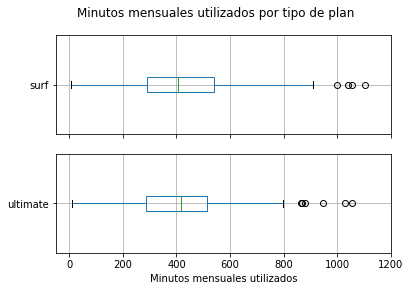

In [93]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
# Se generasn subplots
fig, axes = plt.subplots(2, 1, sharex=True)
# Para el plan surf
# Se genera un diagrama de cajas
all_users_month_plans[all_users_month_plans['plan'] == 'surf']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().rename('surf').to_frame().boxplot(ax=axes[0], vert=False)
# Para el plan ultimate
# Se genera un diagrama de cajas
all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['charged_duration'].replace(0, np.nan).groupby('user_id').mean().rename('ultimate').to_frame().boxplot(ax=axes[1], vert=False)
plt.xlabel('Minutos mensuales utilizados')
plt.xlim([-50, 1200])
fig.suptitle('Minutos mensuales utilizados por tipo de plan ')
plt.show()

Se puede observar que las graficas que describen el comportamiento de los usuarios son similares. En el caso de la duracion promedio de llamadas, estas suelen durar aprox. 7 minutos para cada tipo de plan; tendencia que se mantiene a lo largo del anho. En relacion a las distribuciones de minutos utilizados, ambas presentan medias y medianas cercanas a 400 minutos promedio mensuales y un ligero sesgo hacia la derecha.

Sin embargo, podemos apreciar que la distribucion del plan surf presenta una mayor cantidad de instancias, una menor moda y tiene una cola derecha mas alargada (Q3 mas alto y bigote derecho mas largo). Es decir, los valores se encuentran mas dispersos.

Finalmente, podemos observar que casi la mitad de los usuarios del plan surf se exceden en la cantidad de minutos que brinda su plan. Dado el bajo costo por cada minuto extra, no parece probable poder ofrecerles un plan alternativo.

### Mensajes

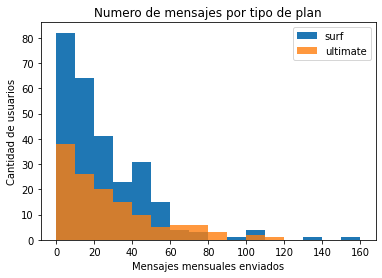

In [94]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
all_users_month_plans[all_users_month_plans['plan'] == 'surf']['messages'].replace(0, np.nan).groupby('user_id').mean().plot(kind='hist', 
                                                                                                                            bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160])
all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['messages'].replace(0, np.nan).groupby('user_id').mean().plot(kind='hist', 
                                                                                                                            bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
                                                                                                                                alpha=0.8)
plt.ylabel('Cantidad de usuarios')
plt.xlabel('Mensajes mensuales enviados')
plt.legend(['surf', 'ultimate'])
plt.title('Numero de mensajes por tipo de plan')
plt.show()

In [95]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
# Esto va en la seccion internet, se procede con metricas estadisticas de los mensajes
# Plan surf
# Media
avg_month_messages_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']['messages'].replace(0, np.nan).groupby('user_id').mean().fillna(0).mean()
# Varianza
var_month_messages_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']['messages'].replace(0, np.nan).groupby('user_id').mean().fillna(0).var()

# Se imprimen los valores
print('Plan Surf')
print('Media de mensajes mensuales enviados: ', avg_month_messages_surf)
print('Varianza de mensajes mensuales enviados: ', var_month_messages_surf)
print('Desv.Est. de mensajes mensuales enviados: ', np.sqrt(var_month_messages_surf))

# Plan Ultimate
# Media
avg_month_messages_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['messages'].replace(0, np.nan).groupby('user_id').mean().fillna(0).mean()
# Varianza
var_month_messages_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['messages'].replace(0, np.nan).groupby('user_id').mean().fillna(0).var()

# Se imprimen los valores
print('Plan Ultimate')
print('Media de mensajes mensuales enviados: ', avg_month_messages_ultimate)
print('Varianza de mensajes mensuales enviados: ', var_month_messages_ultimate)
print('Desv.Est. de mensajes mensuales enviados: ', np.sqrt(var_month_messages_ultimate))

Plan Surf
Media de mensajes mensuales enviados:  19.903122061455395
Varianza de mensajes mensuales enviados:  526.0464991743875
Desv.Est. de mensajes mensuales enviados:  22.935703590131858
Plan Ultimate
Media de mensajes mensuales enviados:  23.559166505822557
Varianza de mensajes mensuales enviados:  644.832063036083
Desv.Est. de mensajes mensuales enviados:  25.393543727413924


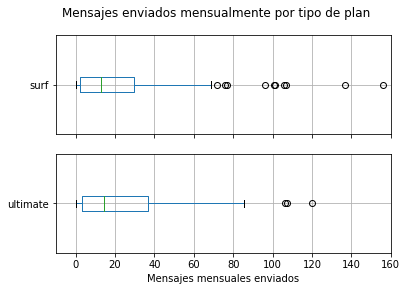

In [96]:
# Se procede a realizar un diagrama de cajas de ambas distribuciones
# Se generasn subplots
fig, axes = plt.subplots(2, 1, sharex=True)
# Para el plan surf
# Se genera un diagrama de cajas
all_users_month_plans[all_users_month_plans['plan'] == 'surf']['messages'].replace(0, np.nan).groupby('user_id').mean().fillna(0).rename('surf').to_frame().boxplot(ax=axes[0], vert=False)
# Para el plan ultimate
# Se genera un diagrama de cajas
all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['messages'].replace(0, np.nan).groupby('user_id').mean().fillna(0).rename('ultimate').to_frame().boxplot(ax=axes[1], vert=False)
plt.xlabel('Mensajes mensuales enviados')
plt.xlim([-10, 160])
fig.suptitle('Mensajes enviados mensualmente por tipo de plan ')
plt.show()

En ambos casos, se puede observar una tendencia similar en la que la mayor cantidad de usuarios envia una menor cantidad de mensajes.

Sin embargo, en el caso del plan surf la pendiente es mucho mas pronunciada. Esto lleva a que tenga una media y mediana menor que el plan ultimate, ya que hay una mayor concentracion de usuarios en el lado izquierdo de la distribucion (menor cantidad de mensajes), y una mayor cantidad de datos atipicos.

Ademas, la distribucion del plan ultimate presenta un mayor sesgo hacia la derecha (se puede apreciar en el bigote derecho mas extendido y en el Q3), lo que concuerda con su mayor dispersion expresada en su mayor varianza.

Podemos decir que si bien las tendencias de comportamiento de los usuarios son similares, existen mayor diferencia que con el caso de las llamadas.

Finalmente, muy pocos usuarios del plan surf mandan mayor cantidad de mensajes de los que tiene su plan.

### Internet

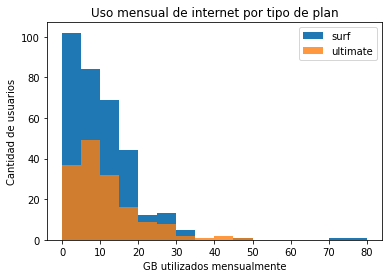

In [97]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
((all_users_month_plans[all_users_month_plans['plan'] == 'surf']['mb_used']) / 1024).replace(0, np.nan).groupby('user_id').mean().plot(kind='hist',
                                                                                                                                      bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
((all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['mb_used']) / 1024).replace(0, np.nan).groupby('user_id').mean().plot(kind='hist', 
                                                                                                                            bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
                                                                                                                                alpha=0.8)
plt.ylabel('Cantidad de usuarios')
plt.xlabel('GB utilizados mensualmente')
plt.legend(['surf', 'ultimate'])
plt.title('Uso mensual de internet por tipo de plan')
plt.show()


In [98]:
# Se calculan estadisticos del consumo de internet
# Plan surf
# Media
avg_month_mb_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']['mb_used'].replace(0, np.nan).groupby('user_id').mean().fillna(0).mean()
# Varianza
var_month_mb_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']['mb_used'].replace(0, np.nan).groupby('user_id').mean().fillna(0).var()

# Se imprimen los valores
print('Plan Surf')
print('Media de GB mensuales utilizados: ', avg_month_mb_surf / 1024)
print('Varianza de GB mensuales utilizados: ', var_month_mb_surf / (1024*1024))
print('Desv.Est. de GB mensuales utilizados: ', np.sqrt(var_month_mb_surf) / 1024)

# Plan Ultimate
# Media
avg_month_mb_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['mb_used'].replace(0, np.nan).groupby('user_id').mean().fillna(0).mean()
# Varianza
var_month_mb_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['mb_used'].replace(0, np.nan).groupby('user_id').mean().fillna(0).var()

# Se imprimen los valores
print('Plan Ultimate')
print('Media de GB mensuales utilizados: ', avg_month_mb_ultimate / 1024)
print('Varianza de GB mensuales utilizados: ', var_month_mb_ultimate / (1024*1024))
print('Varianza de GB mensuales utilizados: ', np.sqrt(var_month_mb_ultimate) / 1024)

Plan Surf
Media de GB mensuales utilizados:  10.607984543647873
Varianza de GB mensuales utilizados:  83.9472430883831
Desv.Est. de GB mensuales utilizados:  9.162272812374837
Plan Ultimate
Media de GB mensuales utilizados:  11.142259701985214
Varianza de GB mensuales utilizados:  79.98502788104888
Varianza de GB mensuales utilizados:  8.943434903942046


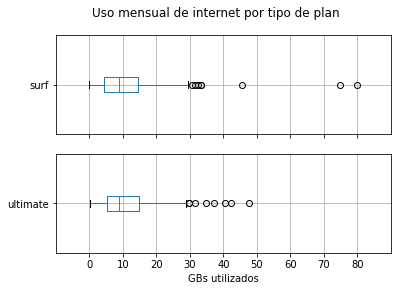

In [99]:
# Se procede a realizar un diagrama de cajas de ambas distribuciones
# Se generasn subplots
fig, axes = plt.subplots(2, 1, sharex=True)
# Para el plan surf
# Se genera un diagrama de cajas
((all_users_month_plans[all_users_month_plans['plan'] == 'surf']['mb_used']) / 1024).replace(0, np.nan).groupby('user_id').mean().fillna(0).rename('surf').to_frame().boxplot(ax=axes[0], vert=False)
# Para el plan ultimate
# Se genera un diagrama de cajas
((all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']['mb_used']) / 1024).replace(0, np.nan).groupby('user_id').mean().fillna(0).rename('ultimate').to_frame().boxplot(ax=axes[1], vert=False)
plt.xlabel('GBs utilizados')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.xlim([-10, 90])
fig.suptitle('Uso mensual de internet por tipo de plan ')
plt.show()

Se puede observar que existen similitudes en el coportamiento de los usuarios en cuanto al consumo de internet. Tenemos dos distribuciones sesgadas a la derecha y una tenedencia a que disminuya la cantidad de usuarios mayor sea el consumo. 

Una diferencia notable es que en el caso de los usuarios del plan ultimate, existe un incremento de usuarios en el rango de 5 a 10 GB, incremento que no existe en los usuarios del plan surf.

Ambas distribuciones presentan datos atipicos luego de los 30 GBs aproximadamente. La diferencia es que en el caso del plan ultimate se encuentran casi uniformemente distribuidos en el rango de 30 a 50 GB. En cambio, en el plan surf estan acumulados alrededor de los 30 GB.

Finalmente, alrededor de 25% de los usuarios del plan surf excede los 15 GB que ofrece su plan (Q3 aproximadamente en 15 GB). Dado el costo de 10 por cada GB utilizado en exceso, otro plan podria servir mejor a sus necesidades. 

## Ingreso

In [100]:
# Se separa el df por tipo de plan
all_users_month_surf = all_users_month_plans[all_users_month_plans['plan'] == 'surf']
all_users_month_ultimate = all_users_month_plans[all_users_month_plans['plan'] == 'ultimate']

In [103]:
# Se calculan los ingresos para cada tipo de plan
# Plan surf
# Ingreso por llamadas
income_calls_user_month_surf = ((all_users_month_surf['charged_duration'] - all_users_month_surf['minutes_included']).clip(0, None))*all_users_month_surf['usd_per_minute']
# Ingreso por mensajes
income_messages_user_month_surf = ((all_users_month_surf['messages'] - all_users_month_surf['messages_included']).clip(0, None))*all_users_month_surf['usd_per_message']
# Ingreso por mbs
income_mb_user_month_surf = (np.ceil(all_users_month_surf['mb_used'] / 1024) - np.ceil(all_users_month_surf['mb_per_month_included'] / 1024)).clip(0, None)*all_users_month_surf['usd_per_gb']
# Ingreso total
income_total_users_month_surf = income_calls_user_month_surf + income_messages_user_month_surf + income_mb_user_month_surf + all_users_month_surf['usd_monthly_pay']

#PLan Ultimate
# Ingreso por llamadas
income_calls_user_month_ultimate = ((all_users_month_ultimate['charged_duration'] - all_users_month_ultimate['minutes_included']).clip(0, None))*all_users_month_ultimate['usd_per_minute']
# Ingreso por mensajes
income_messages_user_month_ultimate = ((all_users_month_ultimate['messages'] - all_users_month_ultimate['messages_included']).clip(0, None))*all_users_month_ultimate['usd_per_message']
# Ingreso por mbs
income_mb_user_month_ultimate = (np.ceil(all_users_month_ultimate['mb_used'] / 1024) - np.ceil(all_users_month_ultimate['mb_per_month_included'] / 1024)).clip(0, None)*all_users_month_ultimate['usd_per_gb']
# Ingreso total
income_total_users_month_ultimate = income_calls_user_month_ultimate + income_messages_user_month_ultimate + income_mb_user_month_ultimate + all_users_month_ultimate['usd_monthly_pay']

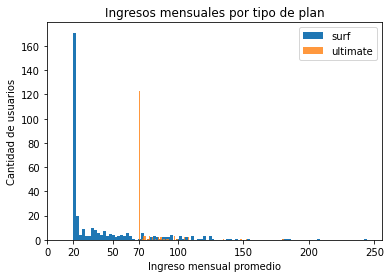

In [105]:
# Se elaboran histogramas para los ingresos producto de cada plan
# PLan surf
income_total_users_month_surf.groupby('user_id').mean().plot(kind='hist',
                                                            bins=100)
# Plan Ultimate
income_total_users_month_ultimate.groupby('user_id').mean().plot(kind='hist',
                                                            bins=100,
                                                                alpha=0.8)
plt.ylabel('Cantidad de usuarios')
# Se 
plt.xlabel('Ingreso mensual promedio')
plt.xticks([0, 20, 50, 70, 100, 150, 200, 250])
plt.legend(['surf', 'ultimate'])
plt.title('Ingresos mensuales por tipo de plan')
plt.show()

In [48]:
# Se calculan estadisticos
#Plan Surf
#Media
avg_month_income_surf = income_total_users_month_surf.groupby('user_id').mean().mean()
# Varianza
var_month_income_surf = income_total_users_month_surf.groupby('user_id').mean().var()

# Se imprimen resultados
print('Plan Surf')
print('Ingreso promedio mensual: ', avg_month_income_surf)
print('Varianza del ingreso promedio mensual: ', var_month_income_surf)
print('Desv. Est. del ingreso promedio mensual: ', np.sqrt(var_month_income_surf))

#Plan Ultimate
#Media
avg_month_income_ultimate = income_total_users_month_ultimate.groupby('user_id').mean().mean()
# Varianza
var_month_income_ultimate = income_total_users_month_ultimate.groupby('user_id').mean().var()

# Se imprimen resultados
print('Plan Ultimate')
print('Ingreso promedio mensual: ', avg_month_income_ultimate)
print('Varianza del ingreso promedio mensual: ', var_month_income_ultimate)
print('Desv. Est. del ingreso promedio mensual: ', np.sqrt(var_month_income_ultimate))

Plan Surf
Ingreso promedio mensual:  40.8839970695804
Varianza del ingreso promedio mensual:  1238.3204455638747
Desv. Est. del ingreso promedio mensual:  35.18977757195795
Plan Ultimate
Ingreso promedio mensual:  75.30148780801646
Varianza del ingreso promedio mensual:  235.09953466579455
Desv. Est. del ingreso promedio mensual:  15.332955835904391


In [49]:
# Debido a la alta concentracion de los datos, esta representacion no resulta util
# Se prefiere el metodo describe
# PLan Surf
print('Plan Surf')
print(income_total_users_month_surf.groupby('user_id').mean().describe())
print('')
#Plan Ultimate
print('Plan Ultimate')
print(income_total_users_month_ultimate.groupby('user_id').mean().describe())

Plan Surf
count    333.000000
mean      40.883997
std       35.189778
min       20.000000
25%       20.043333
50%       22.046667
75%       48.333333
max      244.646364
dtype: float64

Plan Ultimate
count    157.000000
mean      75.301488
std       15.332956
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      180.600000
dtype: float64


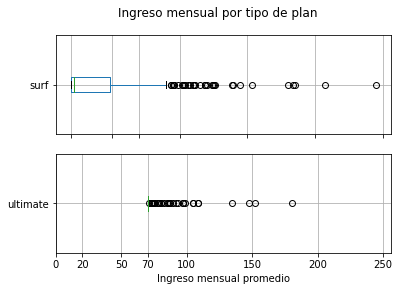

In [50]:
# Se procede con el diagrama de cajas
# Se generasn subplots
fig, axes = plt.subplots(2, 1, sharex=True)
# Para el plan surf
# Se genera un diagrama de cajas
income_total_users_month_surf.groupby('user_id').mean().rename('surf').to_frame().boxplot(ax=axes[0], vert=False)
# Para el plan ultimate
# Se genera un diagrama de cajas
income_total_users_month_ultimate.groupby('user_id').mean().rename('ultimate').to_frame().boxplot(ax=axes[1], vert=False)
plt.xlabel('Ingreso mensual promedio')
# Se resaltan los valores de 20 y 70 por ser los costos fijos de los planes
plt.xticks([0, 20, 50, 70,100, 150, 200, 250])
#plt.xlim([-10, 90])
fig.suptitle('Ingreso mensual por tipo de plan')
plt.show()

Se puede apreciar que ambas distribuciones estan fuertemente localizadas en el costo mensual de cada uno de los planes. Es decir, la mayoria de usuarios gasta mensualmente en promedio el costo de su plan o un poco mas. Esto se ve fuertemente reforzado por los estadisticos y el diagrama de cajas. Se podria decir que en promedio un usuario del plan ultimate es mas rentable para la empresa que uno del plan surf (aunque de estos ultimos hay una mayor cantidad, lo que podria dar una mayor cantidad de ingresos totales; mas no de ingreso por usuario).

Una diferencia existe, los usuarios del plan surf estan mas dispersos, lo cual genera una larga cola derecha en la distribucion. En cambio, los usuarios del plan ultimate estan mucho mas localizados y esto se expresa en los valores de Q1, Q2 y Q3 siendo iguales.

Esa dispersion en aproximadamente la mitad de usarios del plan surf genera una oportunidad interesante... La oportunidad de crear un plan intermedio que se acomode mejor a sus necesidades y produzca o un mayor ingreso a la empresa o uno mas sostenido/predecible. El valor de este plan podria situarse entre 40 y 50 dependiendo de un analisis mas minucioso.

## Prueba las hipótesis estadísticas

- Hipotesis Nula: Los ingresos promedio procedentes de los usuarios de los planes surf y ultimate son iguales.
- Hipotesis Alternativa: Los ingresos promedio procedentes de los usuarios de los planes surf y ultimate son diferentes
- La hipotesis nula se plantea como una igualdad, la hipotesis alternativa como una desigualdad. Buscamos rechazar la hipotesis nula (igualdad) y, por ende, probar la hipotesis alternativa (desigualdad)
- Prueba estadistica a dos colas, alpha de 0.05
- Dado que solo buscamos probar igualdad o desigualdad, utilizamos la preba a dos colas con el valor comun de alpha de 5%.

In [51]:
# Prueba las hipótesis
# Se guardan los valores de ambas distribuciones en listas
surf_income = income_total_users_month_surf.groupby('user_id').mean().tolist()
ultimate_income = income_total_users_month_ultimate.groupby('user_id').mean().tolist()

# Alpha
alpha = 0.05

# Resultados
results = st.ttest_ind(surf_income, ultimate_income, equal_var=False)
print('valor-p:', results.pvalue)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis de que los ingresos promedio procedentes de los usuarios del plan surf son iguales a los ingresos promedio de los usuarios del plan ultimate")
    print("Los ingresos promedio son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula")
    

valor-p: 2.227861741184033e-42
Rechazamos la hipótesis de que los ingresos promedio procedentes de los usuarios del plan surf son iguales a los ingresos promedio de los usuarios del plan ultimate
Los ingresos promedio son diferentes.


- Hipotesis Nula: el ingreso promedio de los usuarios del area NY-NJ es igual al de otras regiones
- Hipotesis Alternativa: el ingreso promedio de los usuarios del anrea NY-NJ es diferente al de otras regiones
- La hipotesis nula se plantea como una igualdad, la hipotesis alternativa como una desigualdad. Buscamos rechazar la hipotesis nula (igualdad) y, por ende, probar la hipotesis alternativa (desigualdad)
- Prueba de dos colas, alpha de 0.05
- Dado que solo buscamos probar igualdad o desigualdad, utilizamos la preba a dos colas con el valor comun de alpha de 5%.

In [52]:
# Se separan los dfs en funcion del area
ny_nj_users = all_users_month_plans[all_users_month_plans['city'].str.contains('NY-NJ')]
non_ny_nj_users = all_users_month_plans[~all_users_month_plans['city'].str.contains('NY-NJ')]

# Se calculan los ingresos mensuales totales por usuario

# NY-NJ
# Ingreso por llamadas
income_calls_ny_nj = ((ny_nj_users['charged_duration'] - ny_nj_users['minutes_included']).clip(0, None))*ny_nj_users['usd_per_minute']
# Ingreso por mensajes
income_messages_ny_nj = ((ny_nj_users['messages'] - ny_nj_users['messages_included']).clip(0, None))*ny_nj_users['usd_per_message']
# Ingreso por mbs
income_mb_ny_nj = (np.ceil(ny_nj_users['mb_used'] / 1024) - np.ceil(ny_nj_users['mb_per_month_included'] / 1024)).clip(0, None)*ny_nj_users['usd_per_gb']
# Ingreso total
income_total_ny_nj = income_calls_ny_nj + income_messages_ny_nj + income_mb_ny_nj + ny_nj_users['usd_monthly_pay']

# Resto
# Ingreso por llamadas
income_calls_non_ny_nj = ((non_ny_nj_users['charged_duration'] - non_ny_nj_users['minutes_included']).clip(0, None))*non_ny_nj_users['usd_per_minute']
# Ingreso por mensajes
income_messages_non_ny_nj = ((non_ny_nj_users['messages'] - non_ny_nj_users['messages_included']).clip(0, None))*non_ny_nj_users['usd_per_message']
# Ingreso por mbs
income_mb_non_ny_nj = (np.ceil(non_ny_nj_users['mb_used'] / 1024) - np.ceil(non_ny_nj_users['mb_per_month_included'] / 1024)).clip(0, None)*non_ny_nj_users['usd_per_gb']
# Ingreso total
income_total_non_ny_nj = income_calls_non_ny_nj + income_messages_non_ny_nj + income_mb_non_ny_nj + non_ny_nj_users['usd_monthly_pay']


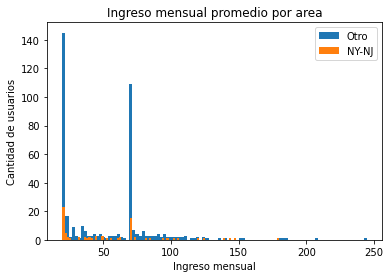

In [53]:
# Se elaboran histogramas para visualizar los comportamientos de los usuarios de ambas areas
income_total_non_ny_nj.groupby('user_id').mean().plot(kind='hist',
                                                 bins=100)
income_total_ny_nj.groupby('user_id').mean().plot(kind='hist',
                                                 bins=100)
plt.ylabel('Cantidad de usuarios')
plt.xlabel('Ingreso mensual')
plt.legend(['Otro', 'NY-NJ'])
plt.title('Ingreso mensual promedio por area')
plt.show()

In [54]:
# Mostramos estadisticos de ambas distrbuciones
#NY-NJ
print('NY-NJ')
print(income_total_ny_nj.describe())
print('Otro')
print(income_total_non_ny_nj.describe())

NY-NJ
count    695.000000
mean      53.225079
std       71.933118
min       20.000000
25%       20.000000
50%       20.600000
75%       70.000000
max      752.550000
dtype: float64
Otro
count    3615.000000
mean       52.584495
std        63.453641
min        20.000000
25%        20.000000
50%        24.170000
75%        70.000000
max      1530.000000
dtype: float64


In [55]:
# Prueba las hipótesis
# Se guardan los valores de ambas distribuciones en listas
ny_nj_income = income_total_ny_nj.groupby('user_id').mean().tolist()
non_ny_nj_income = income_total_non_ny_nj.groupby('user_id').mean().tolist()

# Alpha
alpha = 0.05

# Resultados
results = st.ttest_ind(ny_nj_income, non_ny_nj_income, equal_var=True)
print('valor-p:', results.pvalue)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis de que el ingreso promedio de los usuarios del area NY-NJ sea igual al de otras regiones")
    print("Las diferencias que existen entre os ingresos promedios de ambas areas son muy pequenhas para indicar que existe una diferencia estadistica significativa entre estas.")

valor-p: 0.8738350476031671
No podemos rechazar la hipótesis de que el ingreso promedio de los usuarios del area NY-NJ sea igual al de otras regiones
Las diferencias que existen entre os ingresos promedios de ambas areas son muy pequenhas para indicar que existe una diferencia estadistica significativa entre estas.


## Conclusión general

- El comportamiento de los usuarios de ambos planes es bastante similar en todos los casos (llamadas, mensajes, e internet). Las distribuciones son similares en forma, mas suelen diferir en tamanho debido a la diferencia en el tamanho mismo de las poblaciones (hay mas usuarios del plan surf que del plan ultimate).
- Existen ciertas diferencias a resaltar como que la distribucion de los usuarios del plan surf suele estar mas dispersa, a comparacion con la distribucion de los usuarios del plan utlimate.
- En cuanto a las distribuciones de ingresos mensuales, estas estan fuertemente acumuladas alrededor de los costos mensuales fijos de los planes. Nuevamente el plan surf presentando una distribucion mas dispersa.
- Dada la dispersion en esta ultima distribucion, existe la posibilidad de crear un plan internmedio entre los planes surf y ultimate que se acomode mejor a las necesidades de los usuarios. Esto puede permitir no solo mayores ingresos par la empresa, sino tambien ingresos mas facilmente predecibles (ingresos que no dependen de que los usuarios se excedan o no en sus consumos).
- En cuanto a las hipotesis, se puede probar que existe una diferencia estadistica significativa entre los ingresos promedio de los usuarios del plan surf y del plan ultimate. Esto tambien se puede apreciar facilmente en los histogramas. El ingreso promedio por los usuarios del plan ultimate es mayor que el ingreso pormedio por los usuarios del plan surf. Sin embargo, esto no siginifca que en su totalidad presenten mas ingresos a la companhia, existen mas usuarios del plan surf que del plan ultimate.
- En cuanto a diferencias entre los usuarios del area NY-NJ vs usuarios de otras areas, no existen diferencias estadisticas significativas suficientes para poder decir que los ingresos promedio entre estas dos areas difiere. Esto tambien se puede apreciar facilmente en los histogramas y en los estadisticos. Los ingresos promedio de ambas areas son iguales.